<a href="https://colab.research.google.com/github/niallmirza/QM2/blob/main/FUNCTIONS_Airport_Data_Preparation_%26_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install haversine folium basemap ipywidgets

In [2]:
import pandas as pd
import haversine
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap  # For map visualization
import matplotlib.colors as mcolors  # For custom color scales
import ipywidgets as widgets  # For interactivity
from ipywidgets import interact  # For dynamic updates
from scipy.stats import pearsonr, spearmanr, ttest_rel, ttest_ind, linregress
import base64
import os

In [95]:
# Name of the city where the airport is located
CITY_NAME = "Dallas"
# Name of the airport
AIRPORT_NAME = "Dallas Fort Worth International Airport"
# IATA Code for the airport
AIRPORT_CODE = "DFW"
# Latitude and Longitude of the airport
AIRPORT_LAT, AIRPORT_LON = 32.8990, -97.0336
# Latitude and Longitude for the Basemap
BASEMAP_LAT, BASEMAP_LON = 32.8990, -97.0336
# List of counties for the city the airport serves
AIRPORT_CITY_COUNTIES = ['113', '439']
# The state code for the airport
AIRPORT_STATE_CODE = "48"
# Radius that counts as 'near' the airport
NEARBY_RADIUS = 20
# Set the start and end dates for the analysis
START_DATE, END_DATE = '1999-01-01', '2024-12-31'
# Set the start and end years for the analysis
START_YEAR, END_YEAR = 1999, 2024
# Policy Year for the Hypothesis Test
POLICY_YEAR = 2010

In [18]:
def pd_read_csv_cached(*args, **kwargs):
    os.makedirs("./cached_data", exist_ok=True)

    file_name = args[0]
    safe_file_name = base64.urlsafe_b64encode(file_name.encode('utf-8')).decode('utf-8')
    cached_file_path = f"./cached_data/{safe_file_name}"

    if os.path.exists(cached_file_path):
        return pd.read_pickle(cached_file_path)
    else:
        df = pd.read_csv(*args, **kwargs)
        df.to_pickle(cached_file_path)
        return df

# Add functions for Analysis

In [75]:
def get_pollutant_data(parameter_code, nearby_site_ids_list, all_site_ids_list):
    years = range(START_YEAR, END_YEAR + 1)
    urls = [f"https://aqs.epa.gov/aqsweb/airdata/daily_{parameter_code}_{year}.zip" for year in years]

    # our targeted sites = nearby + all
    target_sites = nearby_site_ids_list + all_site_ids_list

    all_data = []
    for url in urls:
        df = pd_read_csv_cached(url, compression='zip', low_memory=False)
        # Formatting
        df['State Code'] = df['State Code'].astype(str).str.zfill(2)
        df['County Code'] = df['County Code'].astype(str).str.zfill(3)
        df['Site Num'] = df['Site Num'].astype(str).str.zfill(4)
        df['Site Id'] = df['State Code'] + '-' + df['County Code'] + '-' + df['Site Num']
        df['Date Local'] = pd.to_datetime(df['Date Local'], errors='coerce')

        # Filter to only get the targeted sites
        df_target = df[df['Site Id'].isin(target_sites)]
        all_data.append(df_target)

    print("Len of all data: ", len(all_data))

    # Merge each year's data
    all_data = pd.concat(all_data, ignore_index=True)

    # Extract the two sites' data respectively
    df_nearby = all_data[all_data['Site Id'].isin(nearby_site_ids_list)].copy()
    df_all = all_data[all_data['Site Id'].isin(all_site_ids_list)].copy()

    print("Len of nearby data: ", len(df_nearby))
    print("Len of all data: ", len(df_all))

    # Extract daily data：in column 'Arithmetic Mean'

    df_nearby_daily = df_nearby.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='pollutant_mean_nearby')
    df_all_daily = df_all.groupby('Date Local')['Arithmetic Mean'].mean().reset_index(name='pollutant_mean_all')
    df_plot_daily = pd.merge(df_nearby_daily, df_all_daily, on='Date Local', how='inner')

    print("Len of nearby daily data: ", len(df_nearby_daily))
    print("Len of all daily data: ", len(df_all_daily))
    print("Len of plot daily data: ", len(df_plot_daily))

    # Add a 'Year' column to daily data
    all_data['Year'] = all_data['Date Local'].dt.year

    # Group data by 'Site Id' and 'Year', calculate annual average CO
    df_siteyear = (
        all_data
        .groupby(['Site Id', 'Year'], as_index=False)['Arithmetic Mean']
        .mean()
        .rename(columns={'Arithmetic Mean': 'annual_pollutant'})
    )

    return df_nearby_daily, df_all_daily, df_plot_daily, df_nearby, df_all, df_siteyear


In [122]:
def show_daily_line_chart(df_plot_daily, pollutant_name, pollutant_unit):
    # Filter the dataframe df_plot_daily for the specified date range
    df_daily_filtered = df_plot_daily[
        (df_plot_daily['Date Local'] >= START_DATE) &
        (df_plot_daily['Date Local'] <= END_DATE)
    ].copy()

    # Create a numeric_date column for regression analysis
    df_daily_filtered['numeric_date'] = df_daily_filtered['Date Local'].map(pd.Timestamp.toordinal)

    # Perform linear regression for Nearby Sites
    slope_near, intercept_near, r_value_near, p_value_near, std_err_near = linregress(
        df_daily_filtered['numeric_date'],
        df_daily_filtered['pollutant_mean_nearby']
    )

    # Perform linear regression for Other Sites
    slope_all, intercept_all, r_value_all, p_value_all, std_err_all = linregress(
        df_daily_filtered['numeric_date'],
        df_daily_filtered['pollutant_mean_all']
    )

    # Print regression results
    print("==== [DAILY] Regression Analysis (Filtered) ====")
    print("[Nearby Sites]:")
    print(f"  Slope = {slope_near:.6f}, Intercept = {intercept_near:.6f}")
    print(f"  R-value = {r_value_near:.4f},  P-value = {p_value_near:.4g},  StdErr = {std_err_near:.6f}\n")

    print("[Other Sites]:")
    print(f"  Slope = {slope_all:.6f}, Intercept = {intercept_all:.6f}")
    print(f"  R-value = {r_value_all:.4f},  P-value = {p_value_all:.4g},  StdErr = {std_err_all:.6f}\n")

    # Visualization Section
    plt.figure(figsize=(10,6))

    # 1) Line chart for the filtered date range
    sns.lineplot(
        x='Date Local',
        y='pollutant_mean_nearby',
        data=df_daily_filtered,
        label=f'Nearby Sites Daily {pollutant_name} Mean'
    )
    sns.lineplot(
        x='Date Local',
        y='pollutant_mean_all',
        data=df_daily_filtered,
        label=f'Other Sites Daily {pollutant_name} Mean'
    )

    # 2) Add regression lines (calculate y_pred)
    x_vals = df_daily_filtered['numeric_date']
    y_pred_near = slope_near*x_vals + intercept_near
    y_pred_all  = slope_all*x_vals + intercept_all

    # Use the same Date Local as the x-axis
    dates_for_plot = df_daily_filtered['Date Local']

    plt.plot(
        dates_for_plot,
        y_pred_near,
        color='blue',
        linestyle='--',
        label='Regression (Nearby)'
    )
    plt.plot(
        dates_for_plot,
        y_pred_all,
        color='red',
        linestyle='--',
        label='Regression (Other)'
    )

    plt.title(f'Daily {pollutant_name} Concentration with Regression')
    plt.xlabel('Date')
    plt.ylabel(f'Daily Average {pollutant_name} ({pollutant_unit})')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [123]:
def show_annual_line_chart(df_nearby_daily, df_all_daily, pollutant_name, pollutant_unit):
    # Add a 'year' column to the daily data, extracting the year from the 'Date Local' column
    df_nearby_daily['year'] = df_nearby_daily['Date Local'].dt.year
    df_all_daily['year'] = df_all_daily['Date Local'].dt.year

    # Group by 'year' and calculate the mean for each year
    df_nearby_annual = df_nearby_daily.groupby('year')['pollutant_mean_nearby'].mean().reset_index()
    df_all_annual = df_all_daily.groupby('year')['pollutant_mean_all'].mean().reset_index()


    print("Annual mean for nearby sites:\n", df_nearby_annual)

    print(f"\nAnnual mean for other sites in {CITY_NAME}\n", df_all_annual)

    # Maybe looks a little bit messy but gives all the raw annual mean data

    # Merge the two datasets on the 'year' column to facilitate plotting
    df_plot_annual = pd.merge(df_nearby_annual, df_all_annual, on='year', how='inner')


    # Filter the dataframe df_plot_annual for the specified year range
    df_annual_filtered = df_plot_annual[
        (df_plot_annual['year'] >= START_YEAR) &
        (df_plot_annual['year'] <= END_YEAR)
    ].copy()

    # Extract the filtered years
    x_year = df_annual_filtered['year']

    # Perform linear regression for Nearby Sites
    slope_near_annual, intercept_near_annual, r_value_near_annual, p_value_near_annual, std_err_near_annual = linregress(
        x_year,
        df_annual_filtered['pollutant_mean_nearby']
    )

    # Perform linear regression for Other Sites
    slope_all_annual, intercept_all_annual, r_value_all_annual, p_value_all_annual, std_err_all_annual = linregress(
        x_year,
        df_annual_filtered['pollutant_mean_all']
    )

    # Print regression results
    print("==== [ANNUAL] Regression Analysis (Filtered) ====")
    print("[Nearby Sites]:")
    print(f"  Slope = {slope_near_annual:.6f}, Intercept = {intercept_near_annual:.6f}")
    print(f"  R-value = {r_value_near_annual:.4f},  P-value = {p_value_near_annual:.4g},  StdErr = {std_err_near_annual:.6f}\n")

    print("[Other Sites]:")
    print(f"  Slope = {slope_all_annual:.6f}, Intercept = {intercept_all_annual:.6f}")
    print(f"  R-value = {r_value_all_annual:.4f},  P-value = {p_value_all_annual:.4g},  StdErr = {std_err_all_annual:.6f}\n")

    # Visualization Section
    plt.figure(figsize=(10,5))

    # Line chart for annual pollutant values (filtered by the specified year range)
    sns.lineplot(
        x='year',
        y='pollutant_mean_nearby',
        data=df_annual_filtered,
        marker='o',
        label=f'Nearby Sites Annual {pollutant_name} Mean'
    )
    sns.lineplot(
        x='year',
        y='pollutant_mean_all',
        data=df_annual_filtered,
        marker='o',
        label=f'Other Sites Annual {pollutant_name} Mean'
    )

    # Add regression lines
    y_pred_near_annual = slope_near_annual * x_year + intercept_near_annual
    y_pred_all_annual  = slope_all_annual  * x_year + intercept_all_annual

    plt.plot(
        x_year,
        y_pred_near_annual,
        color='blue',
        linestyle='--',
        label='Regression (Nearby)'
    )
    plt.plot(
        x_year,
        y_pred_all_annual,
        color='red',
        linestyle='--',
        label='Regression (Other)'
    )

    plt.title(f'Annual {pollutant_name} Concentration with Regression')
    plt.xlabel('Year')
    plt.ylabel(f'Annual Average {pollutant_name} ({pollutant_unit})')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
def show_other_visualisations(df_nearby, df_all, pollutant_name, pollutant_unit):
    # Calculate annual mean CO for nearby sites
    df_nearby_annual = df_nearby.copy()
    df_nearby_annual['Year'] = df_nearby_annual['Date Local'].dt.year
    df_nearby_annual = (
        df_nearby_annual.groupby('Year', as_index=False)['Arithmetic Mean']
        .mean()
        .rename(columns={'Arithmetic Mean': 'pollutant_annual_mean_nearby'})
    )

    # Calculate annual mean CO for all sites
    df_all_annual = df_all.copy()
    df_all_annual['Year'] = df_all_annual['Date Local'].dt.year
    df_all_annual = (
        df_all_annual.groupby('Year', as_index=False)['Arithmetic Mean']
        .mean()
        .rename(columns={'Arithmetic Mean': 'pollutant_annual_mean_all'})
    )

    df_nearby_annual = df_nearby_annual.loc[
        (df_nearby_annual['Year'] >= START_YEAR) &
        (df_nearby_annual['Year'] <= END_YEAR)
    ]
    df_all_annual = df_all_annual.loc[
        (df_all_annual['Year'] >= START_YEAR) &
        (df_all_annual['Year'] <= END_YEAR)
    ]

    # Prepare long-format data for visualization
    df_nearby_long_annual = df_nearby_annual[['Year','pollutant_annual_mean_nearby']].rename(
        columns={'pollutant_annual_mean_nearby':'pollutant_annual_mean'}
    )
    df_nearby_long_annual['Zone'] = 'Nearby'

    df_all_long_annual = df_all_annual[['Year','pollutant_annual_mean_all']].rename(
        columns={'pollutant_annual_mean_all':'pollutant_annual_mean'}
    )
    df_all_long_annual['Zone'] = 'Others'

    # Combine nearby and all site data for visualization
    df_annual_comparison = pd.concat([df_nearby_long_annual, df_all_long_annual], ignore_index=True)

    # Create a box plot to compare annual mean pollutant distribution by zone
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Zone', y='pollutant_annual_mean', data=df_annual_comparison)
    plt.title(f'{pollutant_name} Distribution by Zone (Annual Mean)')
    plt.ylabel(f'Annual Mean {pollutant_name} ({pollutant_unit})')
    plt.show()

    # Create a violin plot to compare annual mean pollutant distribution by zone
    plt.figure(figsize=(8,6))
    sns.violinplot(x='Zone', y='pollutant_annual_mean', data=df_annual_comparison)
    plt.title(f'{pollutant_name} Distribution by Zone (Annual Mean) - Violin Plot')
    plt.ylabel(f'Annual Mean {pollutant_name} ({pollutant_unit})')
    plt.show()

In [23]:
def spatial_analysis(df_siteyear, pollutant_name, pollutant_unit, site_locations):

    # Merge with site coordinates
    site_locations_reset = site_locations.reset_index()
    df_siteyear_merged = pd.merge(
        df_siteyear,
        site_locations_reset[['Site Id', 'Latitude', 'Longitude']],
        on='Site Id', how='inner'
    )

    # Clean data and define pollutant value range for color scaling
    df_siteyear_merged.dropna(subset=['annual_pollutant', 'Latitude', 'Longitude'], inplace=True)
    vmin, vmax = df_siteyear_merged['annual_pollutant'].min(), df_siteyear_merged['annual_pollutant'].max()

    # Define custom color map (Green -> Yellow -> Red)
    my_cmap = mcolors.LinearSegmentedColormap.from_list('colormap', ['green', 'yellow', 'red'])

    # Function to plot map for a selected year
    def plot_map_for_year(year):
        """Plot annual pollutant data for the given year."""
        df_year = df_siteyear_merged[df_siteyear_merged['Year'] == year]
        plt.figure(figsize=(8, 8))

        # Create Basemap focused on Atlanta
        m = Basemap(projection='lcc', resolution='l', lat_0=BASEMAP_LAT, lon_0=BASEMAP_LON, width=4e5, height=4e5)
        m.drawcoastlines(), m.drawcountries(), m.drawstates()

        # Mark airport location with a star
        x_airport, y_airport = m(AIRPORT_LON, AIRPORT_LAT)
        m.plot(x_airport, y_airport, marker='*', color='black', markersize=14, label=f'{AIRPORT_CODE} Airport')

        # Add a radius circle
        m.tissot(AIRPORT_LON, AIRPORT_LAT, NEARBY_RADIUS / 111.0, 100, facecolor='none', edgecolor='red', linewidth=2, alpha=0.8)

        # Plot pollutant levels for sites
        x, y = m(df_year['Longitude'].values, df_year['Latitude'].values)
        sc = m.scatter(x, y, c=df_year['annual_pollutant'], cmap=my_cmap, vmin=vmin, vmax=vmax, s=60, alpha=0.8, edgecolors='white', linewidths=0.5)

        # Add colorbar and title
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.03)
        cbar.set_label(f'Annual Average {pollutant_name} ({pollutant_unit})')
        plt.title(f"Annual {pollutant_name} in {CITY_NAME} Region - {year}")
        plt.legend(loc='lower left')
        plt.show()

    # Create interactive dropdown for year selection
    all_years = sorted(df_siteyear_merged['Year'].unique())
    interact(
        plot_map_for_year,
        year=widgets.Dropdown(options=all_years, value=all_years[0], description='Select Year:')
    )

In [24]:
def correlation_proximity_analysis(df_siteyear, pollutant_name, pollutant_unit, distances):
    """

    Analyze the relationship between distance and pollutant concentration at the site level.

    Instruction:
    you can first calculate the pollutant concentration for a specific year (or multi-year average),
    and then perform a correlation analysis with the site distances.
    """
    num_years = (END_YEAR - START_YEAR)

    # (1) Calculate the average pollutant for each site for the date range.
    #   You can adjust this to other time periods or focus only on one specific year.
    df_yr = df_siteyear[(df_siteyear['Year'] >= START_YEAR) & (df_siteyear['Year'] <= END_YEAR)]
    df_yr_avg = df_yr.groupby('Site Id', as_index=False)['annual_pollutant'].mean().rename(columns={'annual_pollutant': 'pollutant_yr_mean'})

    # (2) Merge with distance information
    dist_df = pd.DataFrame(list(distances.items()), columns=['Site Id', 'distance_km'])
    df_yr_merged = pd.merge(df_yr_avg, dist_df, on='Site Id', how='inner')

    # (3) Perform correlation analysis
    pearson_corr, pearson_pval = pearsonr(df_yr_merged['distance_km'], df_yr_merged['pollutant_yr_mean'])
    spearman_corr, spearman_pval = spearmanr(df_yr_merged['distance_km'], df_yr_merged['pollutant_yr_mean'])

    print(f"Pearson correlation coefficient between {num_years}-year average {pollutant_name} and distance ({START_YEAR}-{END_YEAR}): {pearson_corr:.4f}, p-value: {pearson_pval:.4g}")
    print(f"Spearman correlation coefficient between {num_years}-year average {pollutant_name} and distance ({START_YEAR}-{END_YEAR}): {spearman_corr:.4f}, p-value: {spearman_pval:.4g}")

    # Visualize scatter plot
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='distance_km', y='pollutant_yr_mean', data=df_yr_merged, alpha=0.7)
    plt.xlabel('Distance from Airport (km)')
    plt.ylabel(f'Average {pollutant_name} ({pollutant_unit})')
    plt.title(f'{pollutant_name} concentration vs. Distance ({START_YEAR}-{END_YEAR})')
    plt.show()

In [25]:
def get_hypothesis_testing_data(df_plot_daily):
    # Filter the data for the study period
    df_plot_daily['Year'] = df_plot_daily['Date Local'].dt.year
    df_plot_daily_2 = df_plot_daily[
        (df_plot_daily['Year'] >= START_YEAR) &
        (df_plot_daily['Year'] <= END_YEAR)
    ].dropna(subset=['pollutant_mean_nearby', 'pollutant_mean_all']).copy()

    print(f"After filtering {START_YEAR} to {END_YEAR}, total records: {len(df_plot_daily_2)}")
    return df_plot_daily_2

In [26]:
def test_proximity_hypothesis(df_plot_daily_hypothesis_testing, pollutant_name):
    # Hypothesis 1: Near vs. Far (Paired t-test)
    """
    H0: The mean daily pollutant concentration is the same for nearby and far sites.
    H1: The mean daily pollutant concentration is different for the two groups.
    (Using paired t-test, because each Date corresponds to a paired measurement:
    one from near sites, one from far sites, on the same day.)
    """

    print(f"[Hypothesis 1] Paired t-test: near vs. far, daily {pollutant_name} from {START_YEAR} to {END_YEAR}")

    if len(df_plot_daily_hypothesis_testing) < 2: # Check if we have enough data available
        print("Not enough daily paired records to perform t-test.")
    else:
        # Prepare a DataFrame to display the pollutant values for nearby and far sites

        # print("Comparison of pollutant values:\n") (uncomment if you want to see the comparison)
        comparison_df = pd.DataFrame({
            'Date': df_plot_daily_hypothesis_testing['Date Local'],
            f'Nearby {pollutant_name}': df_plot_daily_hypothesis_testing['pollutant_mean_nearby'],
            f'Far {pollutant_name}': df_plot_daily_hypothesis_testing['pollutant_mean_all']
        })
        # print(comparison_df.to_string(index=False))
        # uncomment if you want to see all the daily data comparison


        # Perform the paired t-test on the CO values
        t_stat, p_val = ttest_rel(
            df_plot_daily_hypothesis_testing['pollutant_mean_nearby'],
            df_plot_daily_hypothesis_testing['pollutant_mean_all']
        )
        print(f"\nT-statistic = {t_stat:.4f}, p-value = {p_val:.4g}")
        if p_val < 0.05: # Significant difference found, identify which group has higher mean pollutant level
            print(f"=> Reject H0: There is a significant difference between {pollutant_name} concentration near and far from the airport.")
            if df_plot_daily_hypothesis_testing['pollutant_mean_nearby'].mean() > df_plot_daily_hypothesis_testing['pollutant_mean_all'].mean():
                print(f"=> Nearby sites have higher daily {pollutant_name} on average.")
            else:
                print(f"=> Far sites have higher daily {pollutant_name} on average.")
        else:
            print(f"=> Fail to reject H0: No significant difference was found.")



In [27]:
def test_policy_hypothesis(df_plot_daily_hypothesis_testing, pollutant_name, policy_year):
    """
    Assume that Year=2010 is the dividing line for policy implementation.
    Here, 'pollutant_mean_nearby' is used as an example with an independent samples t-test (Welch’s t-test),
    because 'a certain day in 2009' and 'a certain day in 2010' are not paired observations; they are two independent groups.

    H0: The mean daily pollutant (nearby) is the same before and after the policy.
    H1: The mean daily pollutant (nearby) is different before and after the policy.
    """

    print(f"[Hypothesis 2] Policy effectiveness: before vs. after {policy_year} (nearby sites)")

    # Split the data into two groups: before and after the policy implementation year
    before_policy = df_plot_daily_hypothesis_testing.loc[df_plot_daily_hypothesis_testing['Year'] < policy_year, 'pollutant_mean_nearby']
    after_policy  = df_plot_daily_hypothesis_testing.loc[df_plot_daily_hypothesis_testing['Year'] >= policy_year, 'pollutant_mean_nearby']

    # Perform Welch's t-test to compare the two groups
    t_stat2, p_val2 = ttest_ind(before_policy, after_policy, equal_var=False)  # Welch’s t-test

    # Output the test results
    print(f"T-statistic = {t_stat2:.4f}, p-value = {p_val2:.4g}")
    if p_val2 < 0.05:
        # Significant difference found
        print(f"=> Reject H0: There is a significant difference in near-site {pollutant_name} before vs. after {policy_year}.")
        if after_policy.mean() < before_policy.mean(): # Evaluate policy effectiveness
            print("=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.")
        else:
            print("=> Policy had an adverse effect: emissions significantly increased after implementation.")
    else:
        # No significant difference found
        print("=> Fail to reject H0: No significant difference was found.")

# Read and merge monitoring station information and filter sites by distance

In [99]:
monitors = pd_read_csv_cached('https://aqs.epa.gov/aqsweb/airdata/aqs_monitors.zip', converters={'State Code': str, 'County Code': str, 'Site Number': str})
monitors['Site Id'] = monitors['State Code'] + '-' + monitors['County Code'] + '-' + monitors['Site Number']
# Creates a unique ID for each site
monitors = monitors[monitors['Parameter Code'].isin([81102, 88101, 44201, 42401, 42101, 42602])]
"""
Extracting monitors that contain our desired pollutants (PM10, PM2.5, Ozone, SO2, NO₂, CO)
Ozone (O₃ - ppm): 44201
PM2.5 (µg/m3): 88101
PM10 (µg/m3): 81102
CO (ppm): 42101
SO₂ (ppb): 42401
NO₂ (ppb): 42602
"""

monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')

# Extract the 'year' part of the Last Sample Date column
monitors['Last Year'] = monitors['Last Sample Date'].dt.year
monitors['Fist Year'] = monitors['First Year of Data']

# Filter the monitors, only leave those with 6 pollutants data available from 1999 to 2024.
monitors = monitors[(monitors['State Code'] == AIRPORT_STATE_CODE) & (monitors['County Code'].isin(AIRPORT_CITY_COUNTIES))]

site_locations = monitors[['Site Id', 'Latitude', 'Longitude']]
# Filter the dataframe by Site ID and co-ordinates
site_locations = site_locations.drop_duplicates()
site_locations = site_locations.dropna()
# Creates unique rows for each site and removes any sites that do not contain Latitudes and Longitudes
site_locations = site_locations.set_index('Site Id')

def get_site_distances_km(site_locations, lat, lng):
    site_distances = {}
    for site_id, site_row in site_locations.iterrows():
        site_distances[site_id] = haversine.haversine((lat, lng), (site_row['Latitude'], site_row['Longitude']))
    return site_distances
# A function that finds the distance between inputted co-ordinates and each site. This returns a dictionary of site number and distance.

distances = get_site_distances_km(site_locations, AIRPORT_LAT, AIRPORT_LON)

nearby_site_ids = [site_id for site_id, distance in distances.items() if distance < NEARBY_RADIUS]
# This retrieves all of the site IDs within a specified radius from the airport.
all_site_ids = set(site_locations.index.tolist()) - set(nearby_site_ids)
# All eligible sites in airport area, excluding those within a specified radius.

# Print the results
print(f"Monitors within {NEARBY_RADIUS} km of {AIRPORT_NAME}:")
print(set(nearby_site_ids))
nearby_site_ids_list = list(nearby_site_ids)
print(monitors[monitors['Site Id'].isin(nearby_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))

print("\nOther monitors within the specified counties and time range:")
print(set(all_site_ids))
all_site_ids_list = list(all_site_ids)
print(monitors[monitors['Site Id'].isin(all_site_ids)][['Site Id', 'Parameter Code', 'Parameter Name', 'First Year of Data', 'Last Sample Date']].dropna().groupby(['Parameter Code', 'Parameter Name']).agg({'First Year of Data': 'min', 'Last Sample Date': 'max'}))


Monitors within 20 km of Dallas Fort Worth International Airport:
{'48-113-0044', '48-439-3007', '48-113-0039', '48-113-0048', '48-113-0067', '48-113-2002', '48-439-0004', '48-113-0069', '48-113-0061', '48-113-0070', '48-439-0029', '48-439-1001', '48-439-3009', '48-113-3001', '48-439-3001', '48-113-3002'}
                                         First Year of Data Last Sample Date
Parameter Code Parameter Name                                               
42101          Carbon monoxide                       1979.0       2024-06-30
42401          Sulfur dioxide                        1972.0       2024-06-30
42602          Nitrogen dioxide (NO2)                1972.0       2024-06-30
44201          Ozone                                 1973.0       2024-06-30
81102          PM10 Total 0-10um STP                 1988.0       2024-06-30
88101          PM2.5 - Local Conditions              1999.0       2024-06-30

Other monitors within the specified counties and time range:
{'48-113-1047',

<ipython-input-99-e11c1ea89b16>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['First Year of Data'] = pd.to_numeric(monitors['First Year of Data'], errors='coerce')
<ipython-input-99-e11c1ea89b16>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monitors['Last Sample Date'] = pd.to_datetime(monitors['Last Sample Date'], errors='coerce')
<ipython-input-99-e11c1ea89b16>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

# Plot Monitoring Sites on the map

In [96]:
# Create a Folium map centered at the airport with an adjustable zoom level
m = folium.Map(location=[AIRPORT_LAT, AIRPORT_LON], zoom_start=10)

# Draw a radius circle around the airport to represent the 'nearby' zone
folium.Circle(
    location=[AIRPORT_LAT, AIRPORT_LON],  # Center of the circle (airport location)
    radius=NEARBY_RADIUS * 1000,  # Radius in meters
    color='red',
    fill=False,
    popup=f'{NEARBY_RADIUS} km Radius'  # Tooltip that appears when the circle is clicked
).add_to(m)

# Add markers for 'nearby' sites (within radius of the airport)
for site_id in nearby_site_ids_list:
    # Get latitude and longitude of the site
    lat = site_locations.loc[site_id, 'Latitude']
    lon = site_locations.loc[site_id, 'Longitude']

    # Add a red marker for the site with a popup showing its ID
    folium.Marker(
        location=[lat, lon],  # Site location
        icon=folium.Icon(color='red', icon='info-sign'),  # Red icon for nearby sites
        popup=f"Nearby site: {site_id}"  # Popup text showing the site ID
    ).add_to(m)

# Add markers for 'other' sites (beyond radius from the airport)
for site_id in all_site_ids_list:
    # Get latitude and longitude of the site
    lat = site_locations.loc[site_id, 'Latitude']
    lon = site_locations.loc[site_id, 'Longitude']

    # Add a blue marker for the site with a popup showing its ID
    folium.Marker(
        location=[lat, lon],  # Site location
        icon=folium.Icon(color='blue', icon='info-sign'),  # Blue icon for other sites
        popup=f"Other site: {site_id}"  # Popup text showing the site ID
    ).add_to(m)

# Display the map
m


# **Visualisation for CO: (42101 Carbon Monoxide)**

Merge data

In [124]:
# For CO: Parameter Code 42101
co_nearby_daily, co_all_daily, co_plot_daily, co_nearby, co_all, co_siteyear = get_pollutant_data(42101, nearby_site_ids_list, all_site_ids_list)

co_all['Year'] = co_all['Date Local'].dt.year
print(co_all[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

co_nearby['Year'] = co_nearby['Date Local'].dt.year
print(co_nearby[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

Len of all data:  26
Len of nearby data:  17802
Len of all data:  28698
Len of nearby daily data:  8909
Len of all daily data:  9030
Len of plot daily data:  8627
                       Site Id
Year                          
1999  48-439-0057, 48-439-1002
2000  48-439-0057, 48-439-1002
2001  48-439-0057, 48-439-1002
2002  48-439-1002, 48-439-3011
2003  48-439-1002, 48-439-3011
2004  48-439-1002, 48-439-3011
2005  48-439-1002, 48-439-3011
2006  48-439-1002, 48-439-3011
2007  48-439-1002, 48-439-3011
2008  48-439-1002, 48-439-3011
2009  48-439-1002, 48-439-3011
2010  48-439-1002, 48-439-3011
2011  48-439-1002, 48-439-3011
2012  48-439-1002, 48-439-3011
2013  48-439-1002, 48-439-3011
2014  48-439-1002, 48-439-3011
2015               48-439-1053
2016               48-439-1053
2017               48-439-1053
2018               48-439-1053
2019               48-439-1053
2020               48-439-1053
2021               48-439-1053
2022               48-439-1053
2023               48-439-1053


Visualisation: Daily Line Chart

==== [DAILY] Regression Analysis (Filtered) ====
[Nearby Sites]:
  Slope = -0.000028, Intercept = 21.075812
  R-value = -0.4711,  P-value = 0,  StdErr = 0.000001

[Other Sites]:
  Slope = -0.000016, Intercept = 11.950537
  R-value = -0.2801,  P-value = 2.973e-155,  StdErr = 0.000001



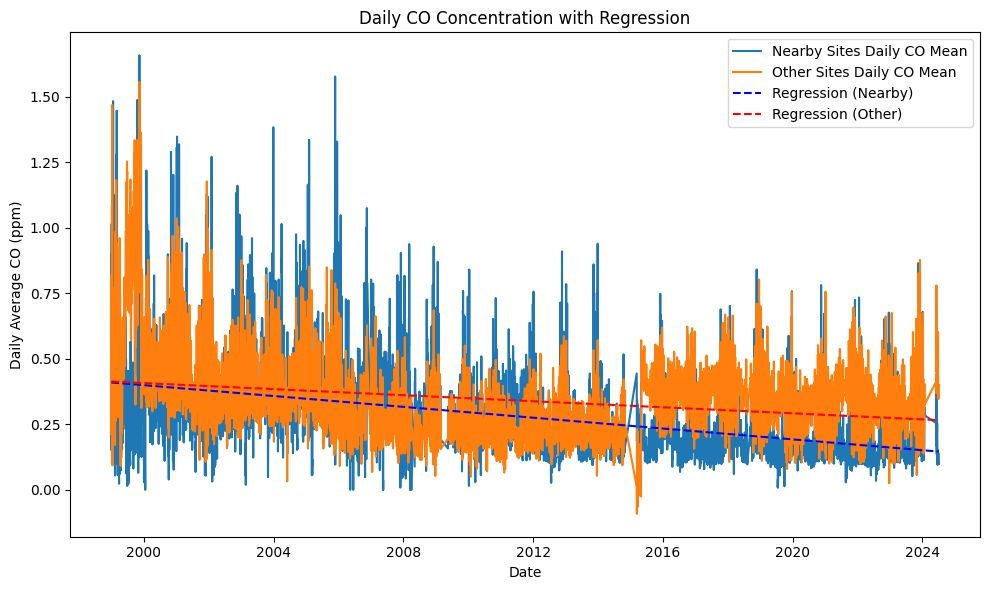

In [125]:
show_daily_line_chart(co_plot_daily, "CO", "ppm")

Visualisation: Annual Line Chart

Annual mean for nearby sites:
     year  pollutant_mean_nearby
0   1999               0.342774
1   2000               0.387544
2   2001               0.386357
3   2002               0.336885
4   2003               0.422337
5   2004               0.411593
6   2005               0.411152
7   2006               0.339342
8   2007               0.373051
9   2008               0.310185
10  2009               0.288854
11  2010               0.263726
12  2011               0.293159
13  2012               0.209442
14  2013               0.232048
15  2014               0.210782
16  2015               0.223485
17  2016               0.213362
18  2017               0.188662
19  2018               0.215659
20  2019               0.181881
21  2020               0.190592
22  2021               0.192289
23  2022               0.176749
24  2023               0.201600
25  2024               0.204189

Annual mean for other sites in Dallas
     year  pollutant_mean_all
0   1999            0.695812
1   200

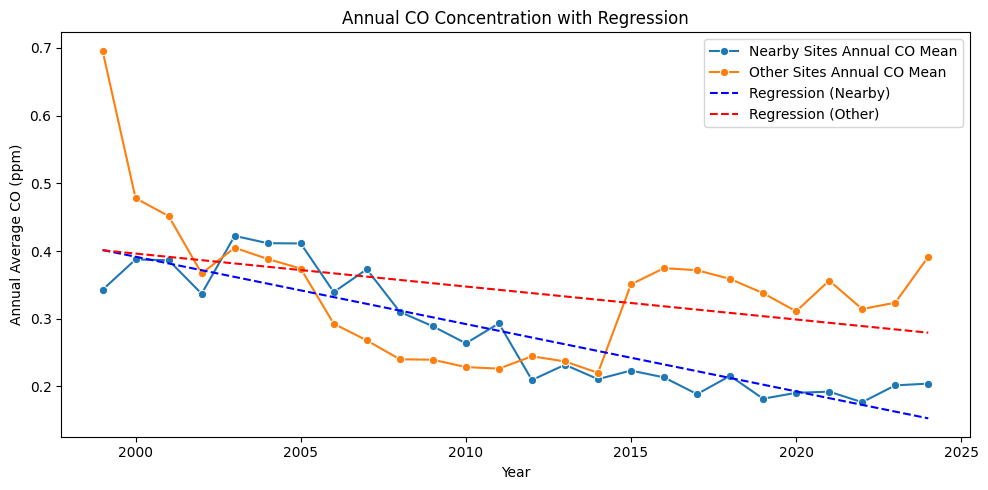

In [126]:
show_annual_line_chart(co_nearby_daily, co_all_daily, "CO", "ppm")

More Visualisation (Box Plot, Violin Plot)

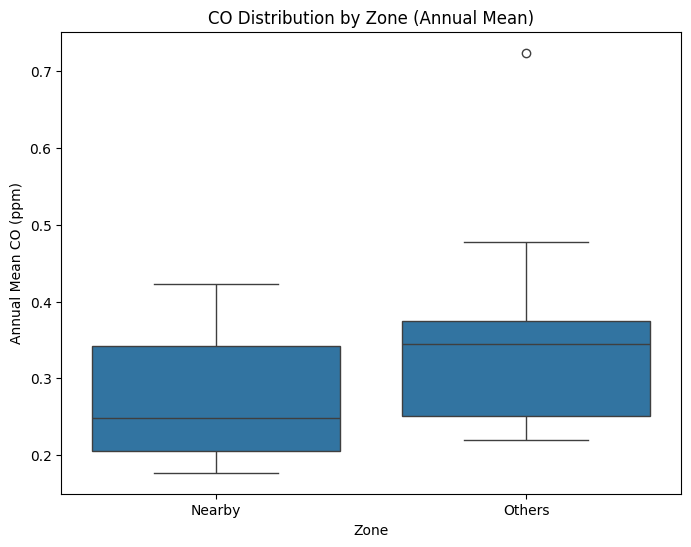

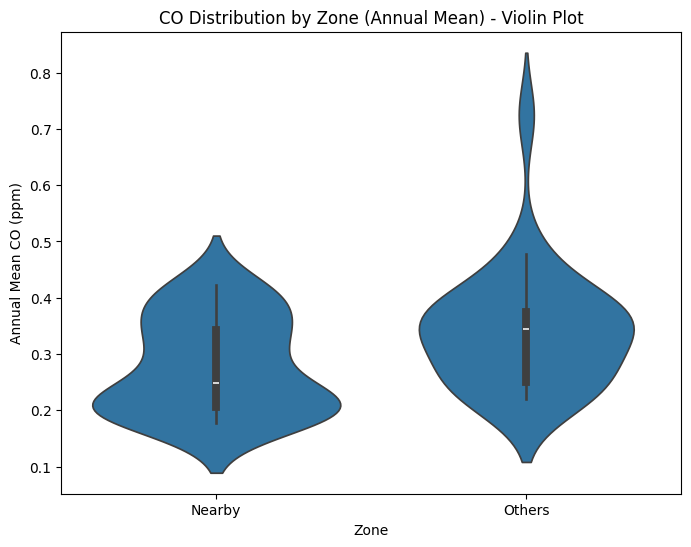

In [127]:
show_other_visualisations(co_nearby, co_all, "CO", "ppm")

Map & Graph : Spatial Analysis

In [128]:
spatial_analysis(co_siteyear, "CO", "ppm", site_locations)


interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

# **Analysis & Hypothesis Testing for CO: (42101 Carbon Monoxide)**

Correlation & Proximity Analysis

Pearson correlation coefficient between 25-year average CO and distance (1999-2024): -0.1032, p-value: 0.8688
Spearman correlation coefficient between 25-year average CO and distance (1999-2024): 0.4000, p-value: 0.5046


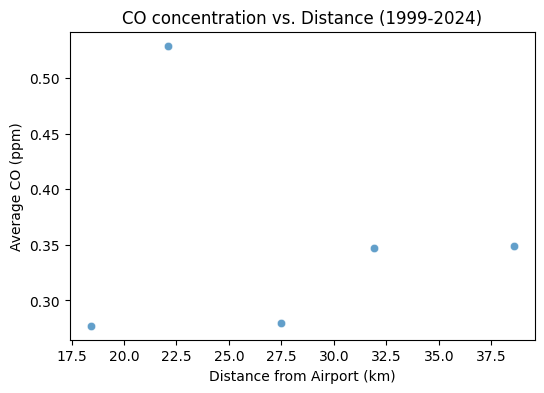

In [129]:
correlation_proximity_analysis(co_siteyear, "CO", "ppm", distances)

# Atlanta intepretation based on the results:

1. **Pearson Correlation Coefficient**:
   - The Pearson correlation coefficient is **-0.6099**, suggesting a moderate negative linear relationship between distance from the airport and the 5-year average CO concentration.

   - The **p-value** is 0.1986, which is greater than 0.05. This indicates that the observed correlation is not statistically significant at the 95% confidence level.

2. **Spearman Correlation Coefficient**:
   - The Spearman correlation coefficient is **-0.2571**, suggesting a weak negative monotonic relationship between distance and CO concentration.
   - The **p-value** is 0.6228, also greater than 0.05, meaning the relationship is not statistically significant as well.

3. **Scatter Plot**:
   - The scatter plot shows some variability in CO concentrations with distance -- Not a strong trend suggesting a definitive relationship

**Interpretation:**
While there appears to be a negative correlation in the Pearson analysis, the lack of statistical significance (high p-values for both Pearson and Spearman tests) suggests that the relationship between distance and CO concentration cannot be reliably concluded.

# Dallas intepretation based on the results:

**Preparation for hypothesis testing**

In [130]:
co_plot_daily_hypothesis_testing = get_hypothesis_testing_data(co_plot_daily)

After filtering 1999 to 2024, total records: 8627


**Hypothesis 1: Does proximity have an impact on air quality**

In [131]:
test_proximity_hypothesis(co_plot_daily_hypothesis_testing, "CO")

[Hypothesis 1] Paired t-test: near vs. far, daily CO from 1999 to 2024

T-statistic = -34.8238, p-value = 9.889e-249
=> Reject H0: There is a significant difference between CO concentration near and far from the airport.
=> Far sites have higher daily CO on average.


**Hypothesis 2: Policy Effectiveness (Before vs. After Policy)**

In [133]:
test_policy_hypothesis(co_plot_daily_hypothesis_testing, "CO", POLICY_YEAR)


[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)
T-statistic = 46.3509, p-value = 0
=> Reject H0: There is a significant difference in near-site CO before vs. after 2010.
=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.


# Visualisation for NO₂: (42602 Nitrogen Dioxide)

Merge data

In [134]:
no2_nearby_daily, no2_all_daily, no2_plot_daily, no2_nearby, no2_all, no2_siteyear = get_pollutant_data(42602, nearby_site_ids_list, all_site_ids_list)

no2_all['Year'] = no2_all['Date Local'].dt.year
print(no2_all[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

no2_nearby['Year'] = no2_nearby['Date Local'].dt.year
print(no2_nearby[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

Len of all data:  26
Len of nearby data:  17509
Len of all data:  46958
Len of nearby daily data:  9227
Len of all daily data:  9313
Len of plot daily data:  9227
                                                Site Id
Year                                                   
1999  48-113-0075, 48-113-0087, 48-439-0057, 48-439-...
2000  48-113-0075, 48-113-0087, 48-439-0057, 48-439-...
2001  48-113-0075, 48-113-0087, 48-439-0057, 48-439-...
2002  48-113-0075, 48-113-0087, 48-439-1002, 48-439-...
2003  48-113-0075, 48-113-0087, 48-439-1002, 48-439-...
2004  48-113-0075, 48-113-0087, 48-439-1002, 48-439-...
2005  48-113-0075, 48-113-0087, 48-439-1002, 48-439-...
2006  48-113-0075, 48-113-0087, 48-439-1002, 48-439-...
2007  48-113-0075, 48-113-0087, 48-439-1002, 48-439-...
2008  48-113-0075, 48-113-0087, 48-439-1002, 48-439-...
2009  48-113-0075, 48-113-0087, 48-439-1002, 48-439-...
2010  48-113-0075, 48-113-0087, 48-439-0075, 48-439-...
2011  48-113-0075, 48-113-0087, 48-439-0075, 48-439-.

Visualisation: Daily Line Chart

==== [DAILY] Regression Analysis (Filtered) ====
[Nearby Sites]:
  Slope = -0.001214, Intercept = 902.433651
  R-value = -0.4844,  P-value = 0,  StdErr = 0.000023

[Other Sites]:
  Slope = -0.000827, Intercept = 617.139340
  R-value = -0.3837,  P-value = 0,  StdErr = 0.000021



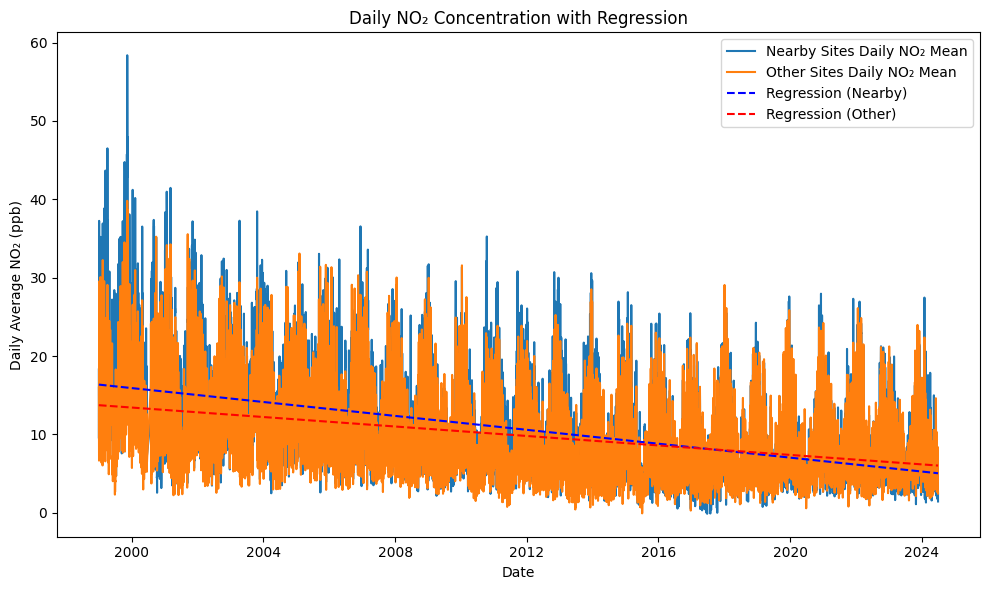

In [135]:
# Merge the two datasets to facilitate plotting
show_daily_line_chart(no2_plot_daily, "NO₂", "ppb")

Visualisation: Annual Line Chart

Annual mean for nearby sites:
     year  pollutant_mean_nearby
0   1999              21.199662
1   2000              17.223193
2   2001              15.470756
3   2002              14.034243
4   2003              14.674443
5   2004              13.414532
6   2005              13.915443
7   2006              12.305573
8   2007              12.477409
9   2008              10.840121
10  2009               9.632101
11  2010              10.432905
12  2011              10.352329
13  2012               9.741394
14  2013               9.093060
15  2014               8.188254
16  2015               7.870492
17  2016               7.379736
18  2017               6.331545
19  2018               7.484065
20  2019               7.646281
21  2020               7.052723
22  2021               7.915471
23  2022               7.999337
24  2023               7.603913
25  2024               7.010215

Annual mean for other sites in Dallas
     year  pollutant_mean_all
0   1999           15.437614
1   200

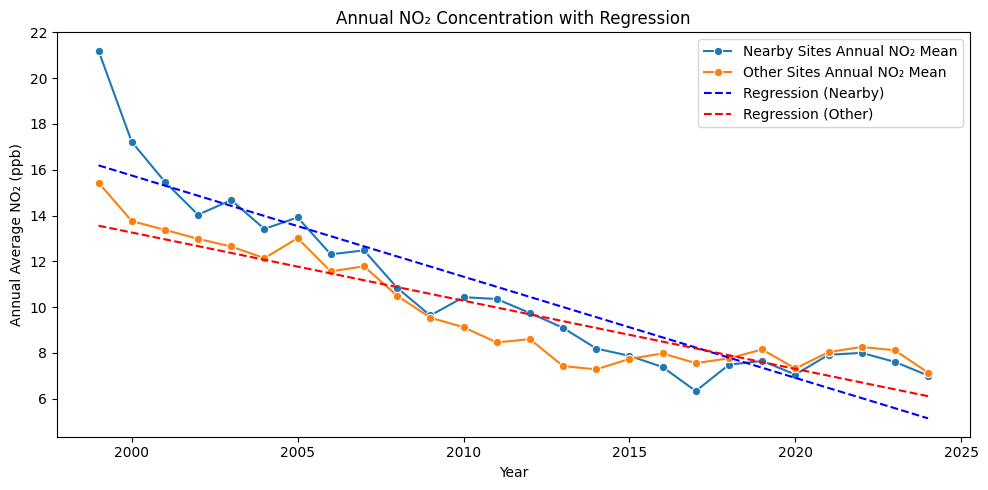

In [136]:
show_annual_line_chart(no2_nearby_daily, no2_all_daily, "NO₂", "ppb")

More Visualisation (Box Plot, Violin Plot)

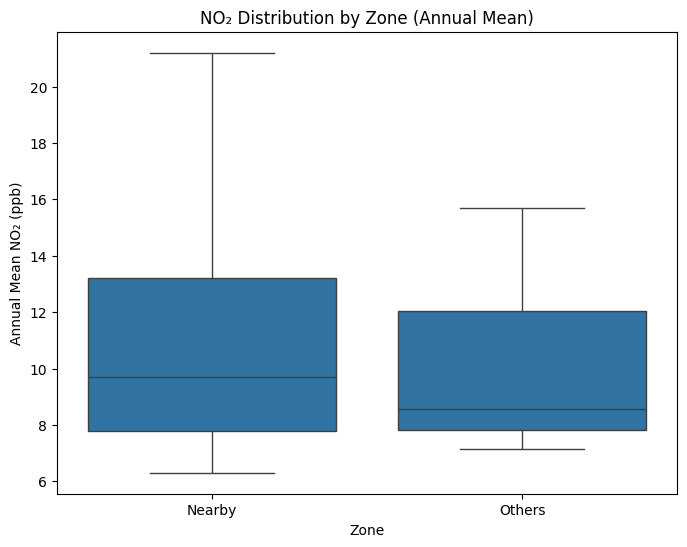

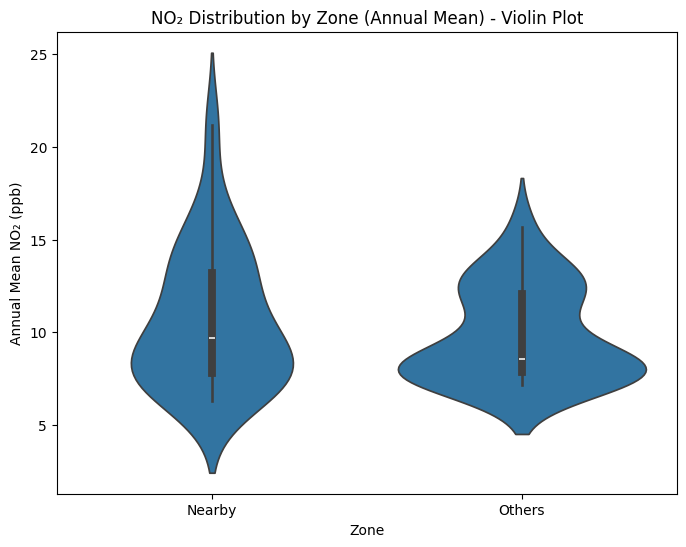

In [137]:
show_other_visualisations(no2_nearby, no2_all, "NO₂", "ppb")


Map & Graph: Spacial Data Analysis

In [138]:
spatial_analysis(no2_siteyear, "NO₂", "ppb", site_locations)

interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

# Analysis & Hypothesis Testing for NO₂: (42602 Nitrogen Dioxide)

Correlation & Proximity Analysis

Pearson correlation coefficient between 25-year average NO₂ and distance (1999-2024): -0.1507, p-value: 0.6584
Spearman correlation coefficient between 25-year average NO₂ and distance (1999-2024): -0.1636, p-value: 0.6307


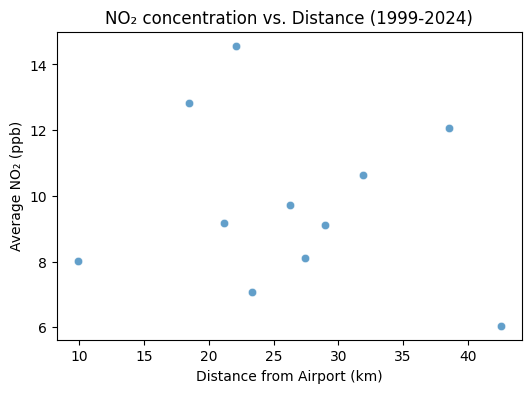

In [139]:
correlation_proximity_analysis(no2_siteyear, "NO₂", "ppb", distances)


Preparation for hypothesis testing

In [140]:
no2_plot_daily_hypothesis_testing = get_hypothesis_testing_data(no2_plot_daily)

After filtering 1999 to 2024, total records: 9227


Hypothesis 1: Does proximity have an impact on air quality

In [141]:
test_proximity_hypothesis(no2_plot_daily_hypothesis_testing, "NO₂")



[Hypothesis 1] Paired t-test: near vs. far, daily NO₂ from 1999 to 2024

T-statistic = 25.3160, p-value = 9.193e-137
=> Reject H0: There is a significant difference between NO₂ concentration near and far from the airport.
=> Nearby sites have higher daily NO₂ on average.


Hypothesis 2: Policy Effectiveness (Before vs. After Policy)

In [142]:
test_policy_hypothesis(no2_plot_daily_hypothesis_testing, "NO₂", POLICY_YEAR)


[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)
T-statistic = 43.5203, p-value = 0
=> Reject H0: There is a significant difference in near-site NO₂ before vs. after 2010.
=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.


# Visualisation for SO₂:(42401 Sulfur Dioxide)

Merge data

In [143]:
so2_nearby_daily, so2_all_daily, so2_plot_daily, so2_nearby, so2_all, so2_siteyear = get_pollutant_data(42401, nearby_site_ids_list, all_site_ids_list)

so2_all['Year'] = so2_all['Date Local'].dt.year
print(so2_all[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

so2_nearby['Year'] = so2_nearby['Date Local'].dt.year
print(so2_nearby[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

Len of all data:  26
Len of nearby data:  17411
Len of all data:  0
Len of nearby daily data:  8712
Len of all daily data:  0
Len of plot daily data:  0
Empty DataFrame
Columns: [Site Id]
Index: []
          Site Id
Year             
1999  48-113-0069
2000  48-113-0069
2001  48-113-0069
2002  48-113-0069
2003  48-113-0069
2004  48-113-0069
2005  48-113-0069
2006  48-113-0069
2007  48-113-0069
2008  48-113-0069
2009  48-113-0069
2010  48-113-0069
2011  48-113-0069
2012  48-113-0069
2013  48-113-0069
2014  48-113-0069
2015  48-113-0069
2016  48-113-0069
2017  48-113-0069
2018  48-113-0069
2019  48-113-0069
2020  48-113-0069
2021  48-113-0069
2022  48-113-0069
2023  48-113-0069
2024  48-113-0069


Visualisation: Daily Line Chart

In [145]:
show_daily_line_chart(so2_plot_daily, "SO₂", "ppm")

ValueError: Inputs must not be empty.

Visualisation: Annual Line Chart

In [146]:
show_annual_line_chart(so2_nearby_daily, so2_all_daily, "SO₂", "ppm")

Annual mean for nearby sites:
     year  pollutant_mean_nearby
0   1999               1.738699
1   2000               1.132470
2   2001               0.974884
3   2002               0.394881
4   2003               0.967032
5   2004               0.816538
6   2005               0.847376
7   2006               0.688160
8   2007               0.310862
9   2008               0.519296
10  2009               0.531430
11  2010               0.636232
12  2011               0.621395
13  2012               0.262083
14  2013               0.175738
15  2014               0.253360
16  2015               0.240127
17  2016               0.207271
18  2017               0.276131
19  2018               0.306987
20  2019               0.337291
21  2020               0.359917
22  2021               0.347469
23  2022               0.661558
24  2023               0.757713
25  2024               0.857104

Annual mean for other sites in Dallas
 Empty DataFrame
Columns: [year, pollutant_mean_all]
Index: []


ValueError: Inputs must not be empty.

More visualisation(Box Plot, Violin Plot)

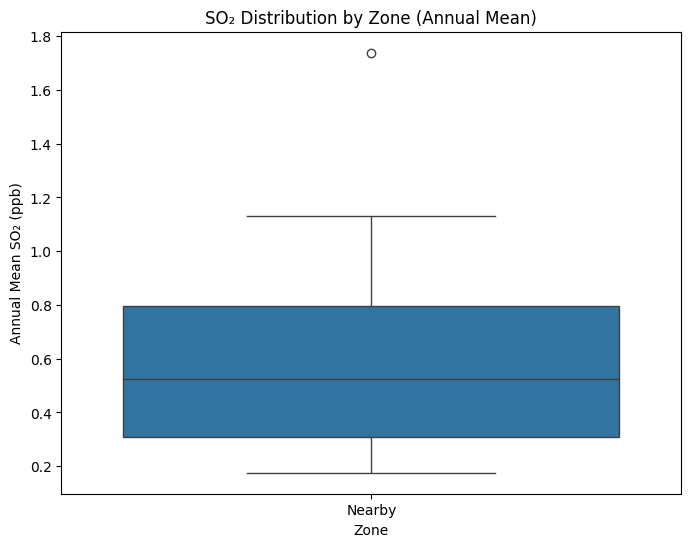

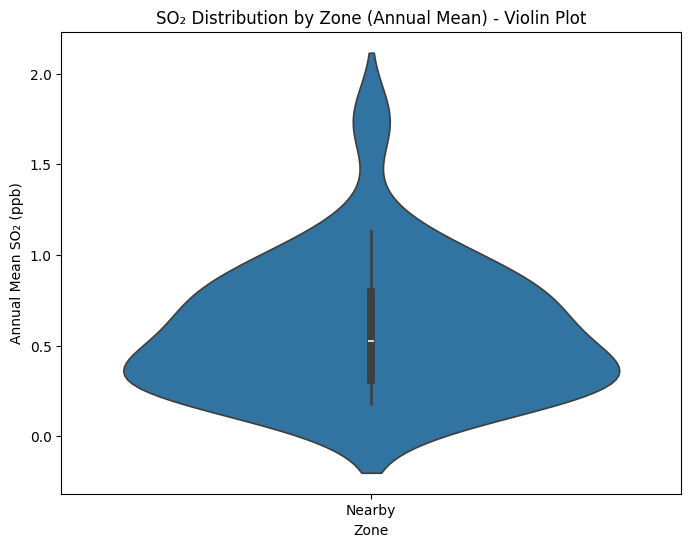

In [147]:
show_other_visualisations(so2_nearby, so2_all, "SO₂", "ppb")


Map & Graph: Spatial Analysis

In [55]:
spatial_analysis(so2_siteyear, "SO₂", "ppb", site_locations)


interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

# Analysis & Hypothesis Testing for SO₂: (42401 Sulfur Dioxide)

Correlation & Proximity Analysis

In [148]:
correlation_proximity_analysis(so2_siteyear, "SO₂", "ppb", distances)


ValueError: x and y must have length at least 2.

Preparation for hypothesis testing

In [149]:
so2_plot_daily_hypothesis_testing = get_hypothesis_testing_data(so2_plot_daily)

After filtering 1999 to 2024, total records: 0


Hypothesis 1: Does proximity have an impact on air quality

In [ ]:
test_proximity_hypothesis(so2_plot_daily_hypothesis_testing, "SO₂")



[Hypothesis 1] Paired t-test: near vs. far, daily SO₂ from 1999 to 2024

T-statistic = -11.5593, p-value = 2.191e-30
=> Reject H0: There is a significant difference between SO₂ concentration near and far from the airport.
=> Far sites have higher daily SO₂ on average.


Hypothesis 2: Policy Effectiveness (Before vs. After Policy)

In [ ]:
test_policy_hypothesis(so2_plot_daily_hypothesis_testing, "SO2", 2009)


[Hypothesis 2] Policy effectiveness: before vs. after 2009 (nearby sites)
T-statistic = 4.8979, p-value = 2.846e-06
=> Reject H0: There is a significant difference in near-site SO2 before vs. after 2009.
=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.


# Visualisation for PM10: (81102)

Merge data

In [150]:
pm10_nearby_daily, pm10_all_daily, pm10_plot_daily, pm10_nearby, pm10_all, pm10_siteyear = get_pollutant_data(81102, nearby_site_ids_list, all_site_ids_list)

pm10_all['Year'] = pm10_all['Date Local'].dt.year
print(pm10_all[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

pm10_nearby['Year'] = pm10_nearby['Date Local'].dt.year
print(pm10_nearby[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

Len of all data:  26
Len of nearby data:  1299
Len of all data:  5144
Len of nearby daily data:  1240
Len of all daily data:  1556
Len of plot daily data:  939
                                                Site Id
Year                                                   
1999  48-113-0018, 48-113-0020, 48-113-0035, 48-113-...
2000  48-113-0018, 48-113-0020, 48-113-0035, 48-113-...
2001  48-113-0018, 48-113-0020, 48-113-0035, 48-113-...
2002  48-113-0018, 48-113-0020, 48-113-0035, 48-113-...
2003  48-113-0018, 48-113-0035, 48-113-0050, 48-113-...
2004  48-113-0035, 48-113-0050, 48-113-0057, 48-439-...
2005  48-113-0035, 48-113-0050, 48-113-0057, 48-439-...
2006  48-113-0035, 48-113-0050, 48-113-0057, 48-439-...
2007  48-113-0035, 48-113-0050, 48-113-0057, 48-439-...
2008  48-113-0035, 48-113-0050, 48-113-0057, 48-439-...
2009              48-113-0050, 48-113-0075, 48-439-3010
2010              48-113-0050, 48-113-0075, 48-439-3010
2011              48-113-0050, 48-113-0075, 48-439-3010


Visualisation: Daily Line Chart

==== [DAILY] Regression Analysis (Filtered) ====
[Nearby Sites]:
  Slope = 0.000486, Intercept = -334.318519
  R-value = 0.1114,  P-value = 0.0006258,  StdErr = 0.000142

[Other Sites]:
  Slope = -0.000201, Intercept = 170.511871
  R-value = -0.0524,  P-value = 0.1089,  StdErr = 0.000125



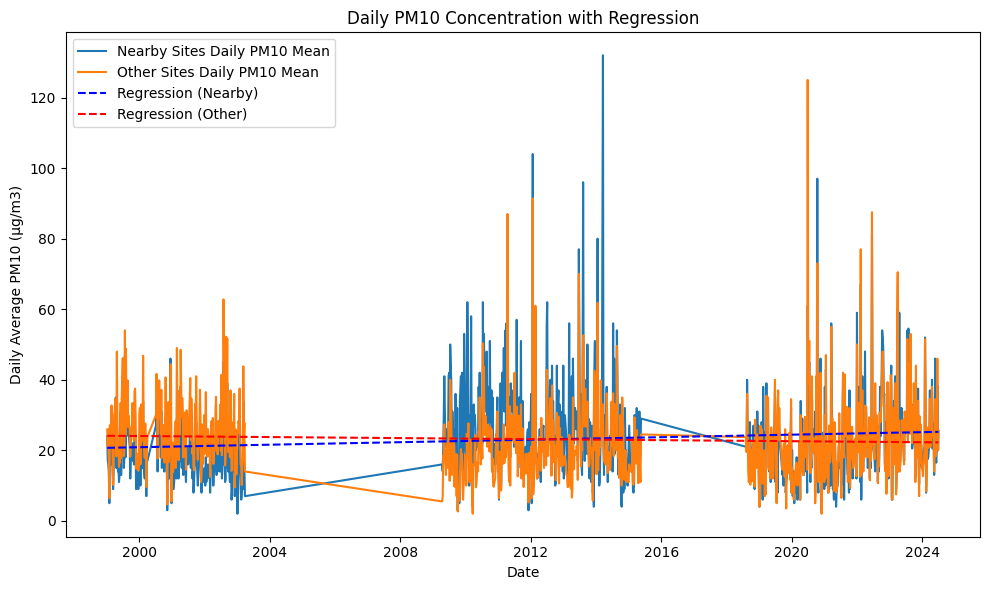

In [151]:
show_daily_line_chart(pm10_plot_daily, "PM10", "µg/m3")

Visualisation: Annual Line Chart

Annual mean for nearby sites:
     year  pollutant_mean_nearby
0   1999              20.596491
1   2000              20.133333
2   2001              17.372881
3   2002              17.383333
4   2003              13.600000
5   2009              26.146341
6   2010              28.448276
7   2011              29.192982
8   2012              26.639344
9   2013              28.456140
10  2014              25.000000
11  2015              19.050000
12  2018              21.000000
13  2019              18.890909
14  2020              21.083333
15  2021              19.216667
16  2022              26.491525
17  2023              28.988208
18  2024              23.046961

Annual mean for other sites in Dallas
     year  pollutant_mean_all
0   1999           26.151508
1   2000           26.188525
2   2001           25.996237
3   2002           25.638525
4   2003           26.375410
5   2004           23.886612
6   2005           26.224044
7   2006           23.976776
8   2007           21.376437

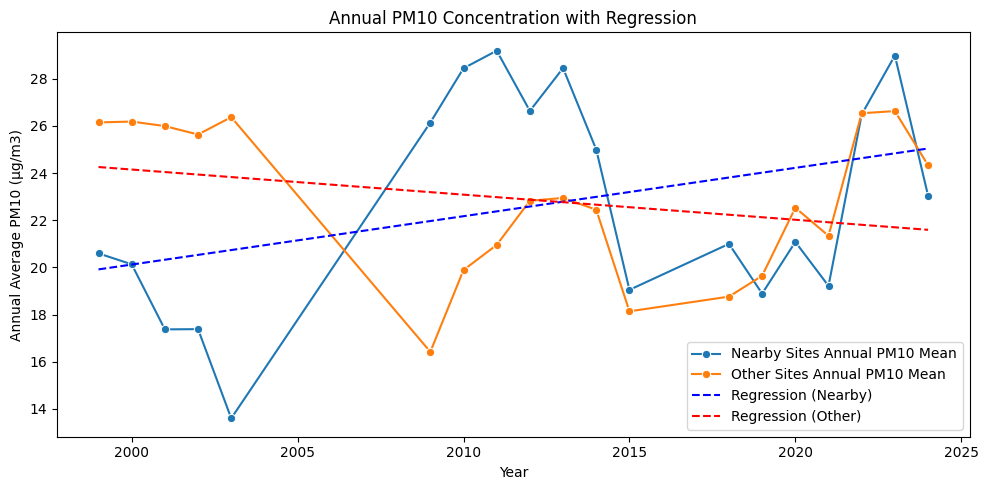

In [153]:
show_annual_line_chart(pm10_nearby_daily, pm10_all_daily, "PM10", "µg/m3")


More Visualisation (Box Plot, Violin Plot)

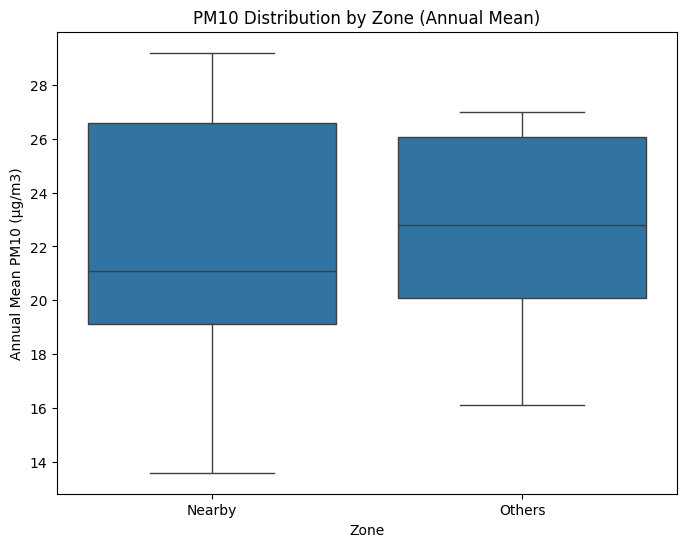

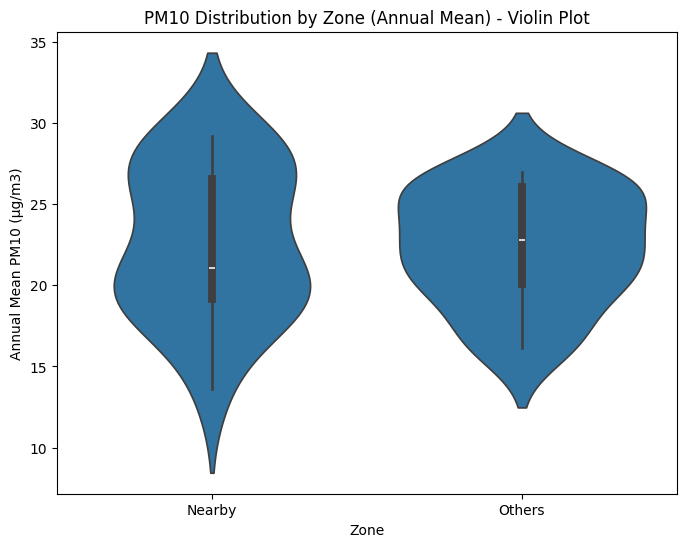

In [154]:
show_other_visualisations(pm10_nearby, pm10_all, "PM10", "µg/m3")

Map & Graph : Spatial Analysis

In [155]:
spatial_analysis(pm10_siteyear, "PM10", "µg/m3", site_locations)

interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

# Analysis & Hypothesis Tesing for PM10:(81102)

Correlation & Proximity Analysis

Pearson correlation coefficient between 25-year average PM10 and distance (1999-2024): -0.0084, p-value: 0.9764
Spearman correlation coefficient between 25-year average PM10 and distance (1999-2024): -0.1571, p-value: 0.576


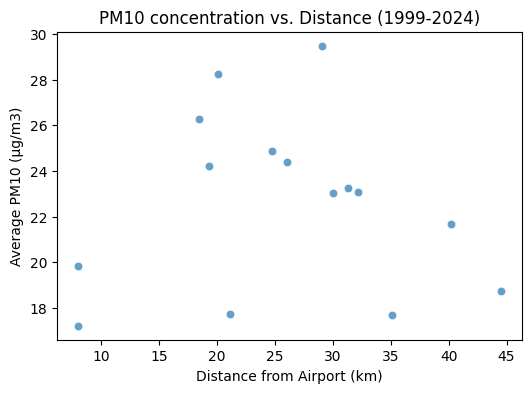

In [156]:
correlation_proximity_analysis(pm10_siteyear, "PM10", "µg/m3", distances)


Preparation for hypothesis testing

In [157]:
pm10_plot_daily_hypothesis_testing = get_hypothesis_testing_data(pm10_plot_daily)

After filtering 1999 to 2024, total records: 939


Hypothesis 1: Does proximity have an impact on air quality

In [158]:
test_proximity_hypothesis(pm10_plot_daily_hypothesis_testing, "PM10")


[Hypothesis 1] Paired t-test: near vs. far, daily PM10 from 1999 to 2024

T-statistic = 0.2893, p-value = 0.7724
=> Fail to reject H0: No significant difference was found.


Hypothesis 2: Policy Effectiveness (Before vs. After Policy)

In [159]:
test_policy_hypothesis(pm10_plot_daily_hypothesis_testing, "PM10", POLICY_YEAR)

[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)
T-statistic = -6.6726, p-value = 4.764e-11
=> Reject H0: There is a significant difference in near-site PM10 before vs. after 2010.
=> Policy had an adverse effect: emissions significantly increased after implementation.


# Visualisation for PM2.5: (88101)

Merge data

In [160]:
pm25_nearby_daily, pm25_all_daily, pm25_plot_daily, pm25_nearby, pm25_all, pm25_siteyear = get_pollutant_data(88101, nearby_site_ids_list, all_site_ids_list)

pm25_all['Year'] = pm25_all['Date Local'].dt.year
print(pm25_all[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

pm25_nearby['Year'] = pm25_nearby['Date Local'].dt.year
print(pm25_nearby[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

Len of all data:  26
Len of nearby data:  17851
Len of all data:  35341
Len of nearby daily data:  8878
Len of all daily data:  6503
Len of plot daily data:  6203
                                                Site Id
Year                                                   
1999  48-113-0020, 48-113-0035, 48-113-0050, 48-113-...
2000  48-113-0020, 48-113-0035, 48-113-0050, 48-113-...
2001  48-113-0020, 48-113-0035, 48-113-0050, 48-113-...
2002  48-113-0020, 48-113-0035, 48-113-0050, 48-113-...
2003  48-113-0035, 48-113-0050, 48-113-0057, 48-113-...
2004  48-113-0035, 48-113-0050, 48-113-0057, 48-113-...
2005  48-113-0035, 48-113-0050, 48-113-0057, 48-113-...
2006  48-113-0050, 48-113-0087, 48-439-1002, 48-439-...
2007  48-113-0050, 48-113-0087, 48-439-1002, 48-439-...
2008  48-113-0050, 48-113-0087, 48-439-1002, 48-439-...
2009  48-113-0050, 48-113-0087, 48-439-1002, 48-439-...
2010  48-113-0050, 48-113-0087, 48-439-1002, 48-439-...
2011              48-113-0050, 48-439-1002, 48-439-10

Visualisation: Daily Line Chart

==== [DAILY] Regression Analysis (Filtered) ====
[Nearby Sites]:
  Slope = -0.000503, Intercept = 380.026187
  R-value = -0.2726,  P-value = 3.655e-106,  StdErr = 0.000023

[Other Sites]:
  Slope = -0.000447, Intercept = 338.657562
  R-value = -0.2526,  P-value = 6.237e-91,  StdErr = 0.000022



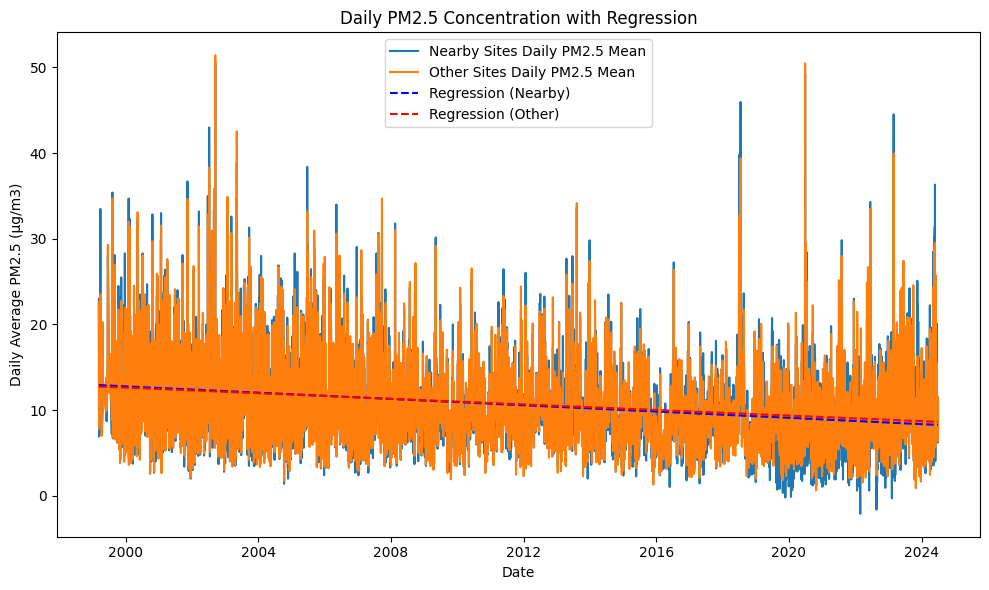

In [161]:
show_daily_line_chart(pm25_plot_daily, "PM2.5", "µg/m3")

Visualisation: Annual Line Chart

Annual mean for nearby sites:
     year  pollutant_mean_nearby
0   1999              13.427564
1   2000              12.779545
2   2001              12.649710
3   2002              12.448110
4   2003              12.608714
5   2004              11.806047
6   2005              12.563689
7   2006              10.818539
8   2007              11.306304
9   2008              10.621045
10  2009               9.895739
11  2010              10.012045
12  2011              10.897974
13  2012              11.083727
14  2013              11.715474
15  2014               9.737333
16  2015               8.807745
17  2016               8.242212
18  2017               8.892447
19  2018               9.498104
20  2019               9.141207
21  2020               8.084508
22  2021               8.192837
23  2022               8.279022
24  2023              10.231130
25  2024              10.181529

Annual mean for other sites in Dallas
     year  pollutant_mean_all
0   1999           13.457542
1   200

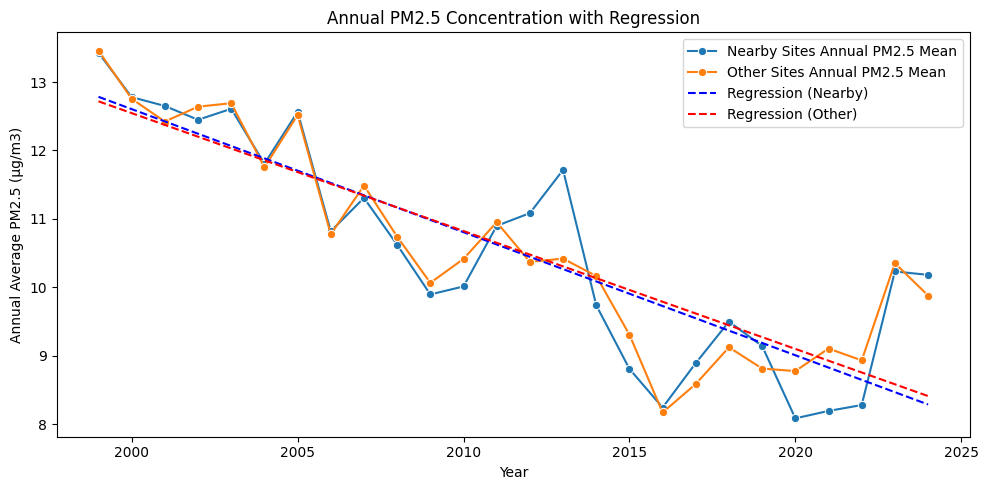

In [163]:
show_annual_line_chart(pm25_nearby_daily, pm25_all_daily, "PM2.5", "µg/m3")


More Visualisation (Box Plot, Violin Plot)

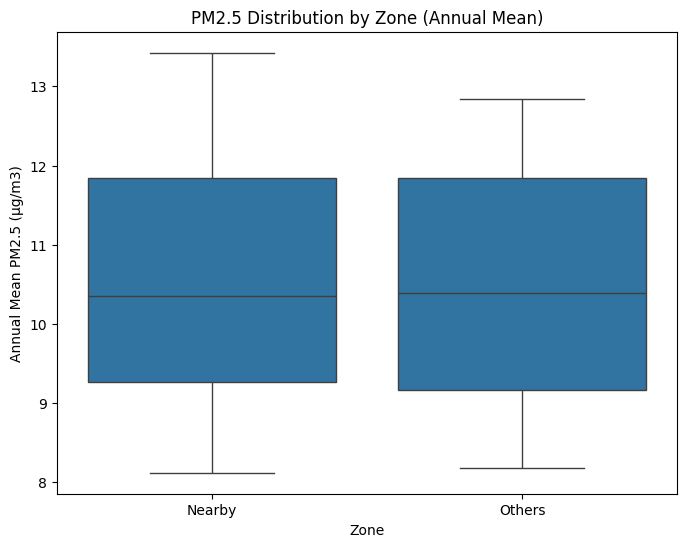

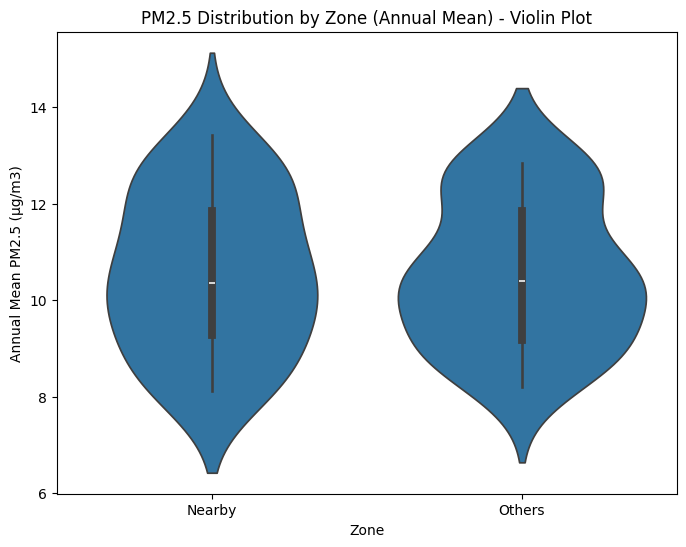

In [164]:
show_other_visualisations(pm25_nearby, pm25_all, "PM2.5", "µg/m3")

Map & Graph : Spatial Analysis

In [165]:
spatial_analysis(pm25_siteyear, "PM2.5", "µg/m3", site_locations)

interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

# Analysis & Hypothesis Tesing for PM2.5:(88101)

Correlation & Proximity Analysis

Pearson correlation coefficient between 25-year average PM2.5 and distance (1999-2024): -0.2885, p-value: 0.3172
Spearman correlation coefficient between 25-year average PM2.5 and distance (1999-2024): -0.3538, p-value: 0.2145


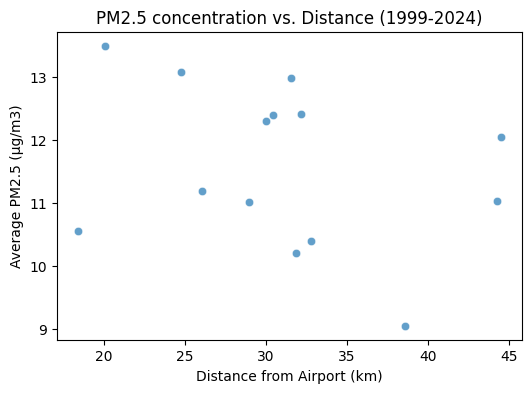

In [166]:
correlation_proximity_analysis(pm25_siteyear, "PM2.5", "µg/m3", distances)


Preparation for hypothesis testing

In [167]:
pm25_plot_daily_hypothesis_testing = get_hypothesis_testing_data(pm25_plot_daily)

After filtering 1999 to 2024, total records: 6203


Hypothesis 1: Does proximity have an impact on air quality

In [168]:
test_proximity_hypothesis(pm25_plot_daily_hypothesis_testing, "PM2.5")


[Hypothesis 1] Paired t-test: near vs. far, daily PM2.5 from 1999 to 2024

T-statistic = -3.8791, p-value = 0.0001059
=> Reject H0: There is a significant difference between PM2.5 concentration near and far from the airport.
=> Far sites have higher daily PM2.5 on average.


Hypothesis 2: Policy Effectiveness (Before vs. After Policy)

In [169]:
test_policy_hypothesis(pm25_plot_daily_hypothesis_testing, "PM2.5", POLICY_YEAR)

[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)
T-statistic = 20.4382, p-value = 7.266e-90
=> Reject H0: There is a significant difference in near-site PM2.5 before vs. after 2010.
=> Policy to reduce emissions is effective: emissions significantly decreased after implementation.


# Visualisation for O₃: (44201)

Merge data

In [170]:
o3_nearby_daily, o3_all_daily, o3_plot_daily, o3_nearby, o3_all, o3_siteyear = get_pollutant_data(44201, nearby_site_ids_list, all_site_ids_list)

o3_all['Year'] = o3_all['Date Local'].dt.year
print(o3_all[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

o3_nearby['Year'] = o3_nearby['Date Local'].dt.year
print(o3_nearby[['Year', 'Site Id']].groupby('Year').agg(lambda x: ', '.join(x.unique())).sort_index())

Len of all data:  26
Len of nearby data:  17691
Len of all data:  55887
Len of nearby daily data:  9288
Len of all daily data:  9313
Len of plot daily data:  9288
                                                Site Id
Year                                                   
1999  48-113-0075, 48-113-0087, 48-439-0057, 48-439-...
2000  48-113-0075, 48-113-0087, 48-113-3003, 48-439-...
2001  48-113-0075, 48-113-0087, 48-113-3003, 48-439-...
2002  48-113-0075, 48-113-0087, 48-113-3003, 48-439-...
2003  48-113-0075, 48-113-0087, 48-113-3003, 48-439-...
2004  48-113-0075, 48-113-0087, 48-113-3003, 48-439-...
2005  48-113-0075, 48-113-0087, 48-113-3003, 48-439-...
2006  48-113-0075, 48-113-0087, 48-113-3003, 48-439-...
2007  48-113-0075, 48-113-0087, 48-439-0075, 48-439-...
2008  48-113-0075, 48-113-0087, 48-439-0075, 48-439-...
2009  48-113-0075, 48-113-0087, 48-439-0075, 48-439-...
2010  48-113-0075, 48-113-0087, 48-439-0075, 48-439-...
2011  48-113-0075, 48-113-0087, 48-439-0075, 48-439-.

Visualisation: Daily Line Chart

==== [DAILY] Regression Analysis (Filtered) ====
[Nearby Sites]:
  Slope = 0.000000, Intercept = -0.139529
  R-value = 0.0501,  P-value = 1.372e-06,  StdErr = 0.000000

[Other Sites]:
  Slope = 0.000000, Intercept = -0.061403
  R-value = 0.0281,  P-value = 0.006853,  StdErr = 0.000000



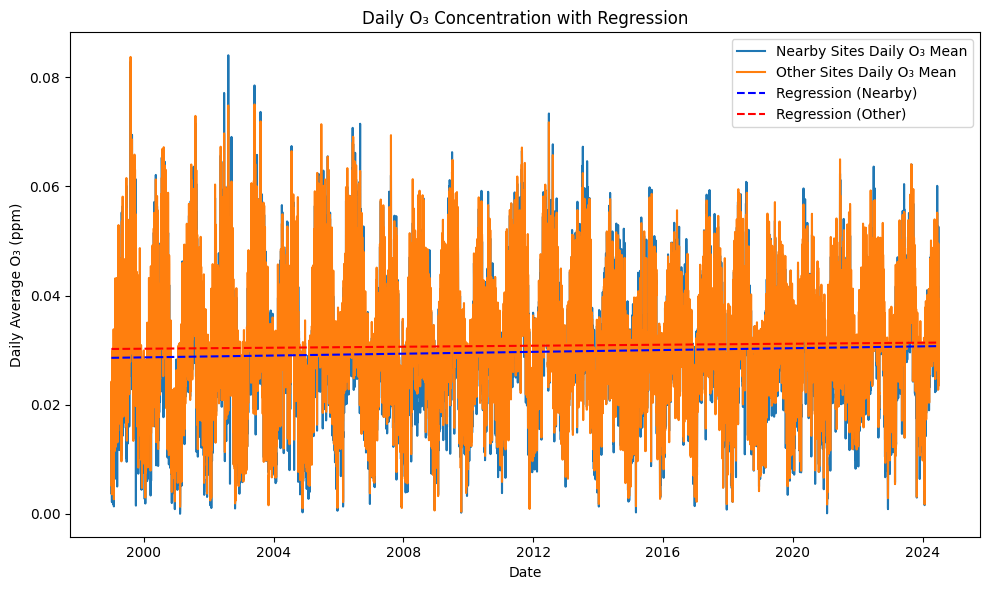

In [171]:
show_daily_line_chart(o3_plot_daily, "O₃", "ppm")

Visualisation: Annual Line Chart

Annual mean for nearby sites:
     year  pollutant_mean_nearby
0   1999               0.027944
1   2000               0.026334
2   2001               0.028349
3   2002               0.028490
4   2003               0.030927
5   2004               0.027583
6   2005               0.030879
7   2006               0.032275
8   2007               0.026850
9   2008               0.027869
10  2009               0.028854
11  2010               0.029236
12  2011               0.032380
13  2012               0.032551
14  2013               0.031674
15  2014               0.030512
16  2015               0.029196
17  2016               0.029555
18  2017               0.030648
19  2018               0.029590
20  2019               0.029331
21  2020               0.028777
22  2021               0.028740
23  2022               0.030393
24  2023               0.031647
25  2024               0.031617

Annual mean for other sites in Dallas
     year  pollutant_mean_all
0   1999            0.030475
1   200

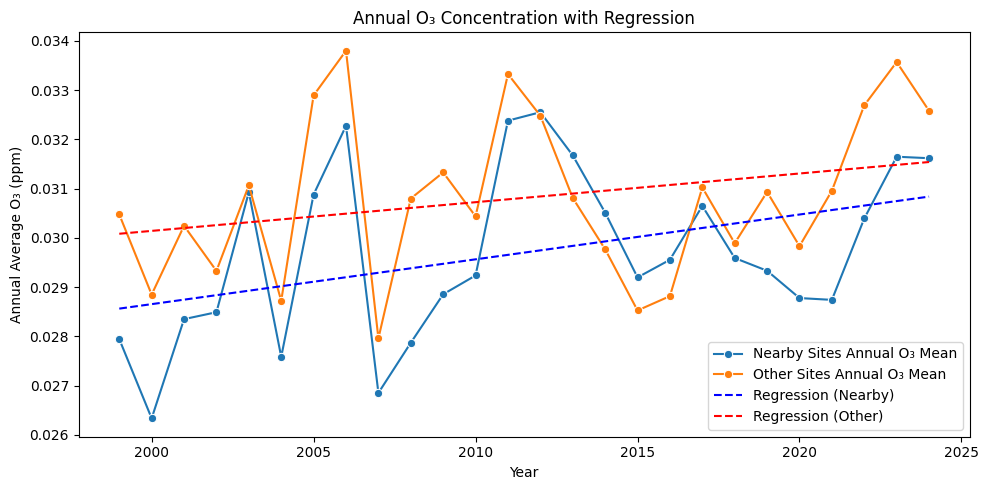

In [172]:
show_annual_line_chart(o3_nearby_daily, o3_all_daily, "O₃", "ppm")


More Visualisation (Box Plot, Violin Plot)

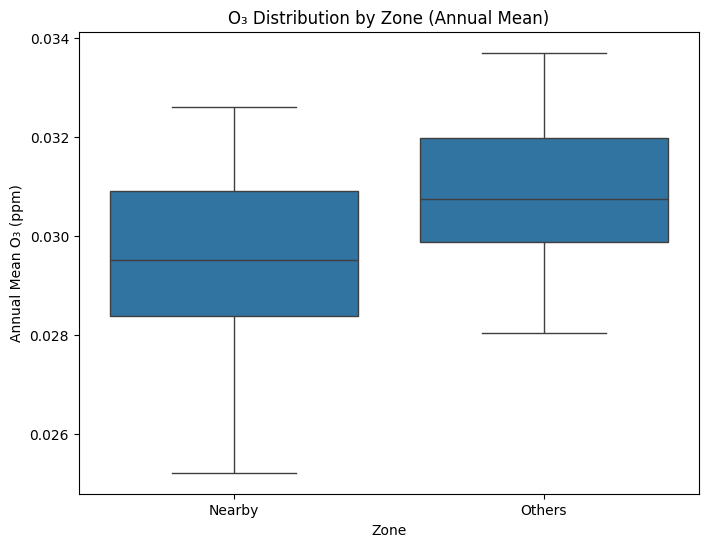

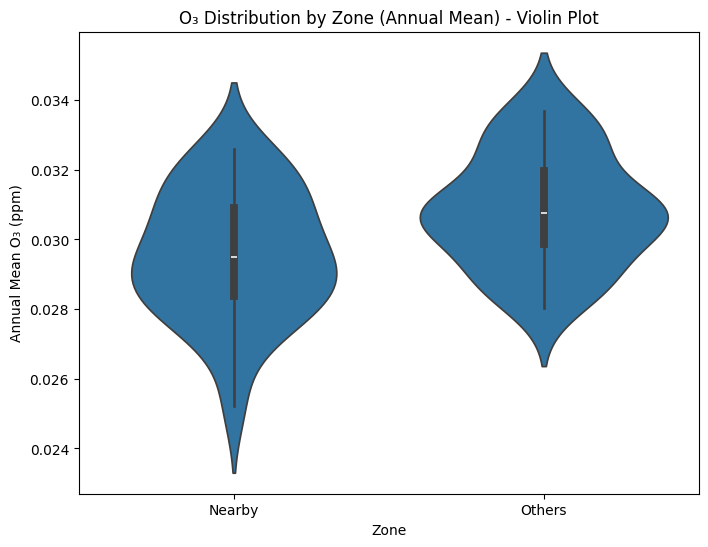

In [175]:
show_other_visualisations(o3_nearby, o3_all, "O₃", "ppm")

Map & Graph : Spatial Analysis

In [176]:
spatial_analysis(o3_siteyear, "O₃", "ppm", site_locations)

interactive(children=(Dropdown(description='Select Year:', options=(1999, 2000, 2001, 2002, 2003, 2004, 2005, …

# Analysis & Hypothesis Tesing for O₃:(44201)

Correlation & Proximity Analysis

Pearson correlation coefficient between 25-year average O₃ and distance (1999-2024): 0.0593, p-value: 0.8708
Spearman correlation coefficient between 25-year average O₃ and distance (1999-2024): 0.0424, p-value: 0.9074


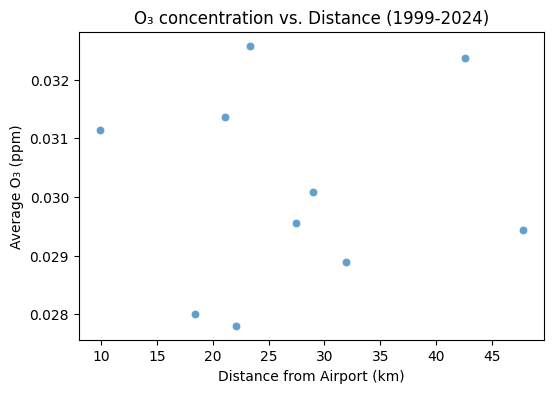

In [177]:
correlation_proximity_analysis(o3_siteyear, "O₃", "ppm", distances)


Preparation for hypothesis testing

In [178]:
o3_plot_daily_hypothesis_testing = get_hypothesis_testing_data(o3_plot_daily)

After filtering 1999 to 2024, total records: 9288


Hypothesis 1: Does proximity have an impact on air quality

In [179]:
test_proximity_hypothesis(o3_plot_daily_hypothesis_testing, "O₃")


[Hypothesis 1] Paired t-test: near vs. far, daily O₃ from 1999 to 2024

T-statistic = -34.9636, p-value = 1.017e-251
=> Reject H0: There is a significant difference between O₃ concentration near and far from the airport.
=> Far sites have higher daily O₃ on average.


Hypothesis 2: Policy Effectiveness (Before vs. After Policy)

In [180]:
test_policy_hypothesis(o3_plot_daily_hypothesis_testing, "O₃", POLICY_YEAR)

[Hypothesis 2] Policy effectiveness: before vs. after 2010 (nearby sites)
T-statistic = -5.9782, p-value = 2.357e-09
=> Reject H0: There is a significant difference in near-site O₃ before vs. after 2010.
=> Policy had an adverse effect: emissions significantly increased after implementation.
